This notebook calculate ITA and add them to dataset.<br>
Masked images are also created in the masked directory.

Input dataset: ham/HAM10000_metadata.csv <br>
Outpit dataset: masked/df.csv

In [1]:
import numpy as np
import pandas as pd
import os
import math
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

import skimage
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb
from skimage import color

from mpl_toolkits.mplot3d import Axes3D

import cv2

In [2]:
# import external codes
%run Colors/Skin_color_functions.ipynb

In [3]:
root = "d:/ham/"
df = pd.read_csv(root + "ham/HAM10000_metadata.csv")

base_skin_dir = "d:/ham/ham"

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['path'] = df['path'].str.replace("\\", "/")
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

df.loc[df['dx'] == "nv", "cell_type_idx"] = "0"
df.loc[df['dx'] == "mel", "cell_type_idx"] = "1"
df.loc[df['dx'] == "bkl", "cell_type_idx"] = "2"
df.loc[df['dx'] == "bcc", "cell_type_idx"] = "3"
df.loc[df['dx'] == "akiec", "cell_type_idx"] = "4"
df.loc[df['dx'] == "vasc", "cell_type_idx"] = "5"
df.loc[df['dx'] == "df", "cell_type_idx"] = "6"
df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
2504,HAM_0006800,ISIC_0029747,bcc,histo,85.0,female,face,d:/ham/ham/HAM10000_images_part_2/ISIC_0029747...,Basal cell carcinoma,3
8120,HAM_0001120,ISIC_0025726,nv,histo,40.0,female,chest,d:/ham/ham/HAM10000_images_part_1/ISIC_0025726...,Melanocytic nevi,0
6849,HAM_0006735,ISIC_0030432,nv,histo,35.0,male,back,d:/ham/ham/HAM10000_images_part_2/ISIC_0030432...,Melanocytic nevi,0


In [4]:
# Rename the columns
new_column_names = {'path': 'filepaths', 'cell_type_idx': 'labels'}
df = df.rename(columns=new_column_names)
df["labels"] = df['labels'].apply(lambda x: str(x))

In [5]:
# image = "d:/ham/ham/HAM10000_images_part_1/ISIC_0025861.jpg"

def skin_image(image):

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_df = pd.DataFrame(img.reshape(-1, 3), columns=["R", "G", "B"])

    kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
    kmeans.fit(color_df)
    color_df["Cluster"] = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Create a mask for the darker cluster
    darker_cluster = 0 if is_darker("RGB", centroids[0], centroids[1]) else 1
    mask = color_df["Cluster"] == darker_cluster

    # Create a mask with the same shape as the image
    mask = mask.values.reshape(img.shape[0], img.shape[1])
    mask = mask.astype(np.uint8)
    masked_image = cv2.bitwise_and(img, img, mask=mask)

    new_filepath = root + "masked/{}".format(os.path.basename(image))
    mask_image = Image.fromarray(masked_image)
    mask_image.save(new_filepath)

    return new_filepath

In [6]:
itas = []
labels = []

samples = df["filepaths"]
for s in samples:
    out_image = skin_image(s)
    ita = ITA(out_image)
    label = ITA_label(ita, None)
    itas.append(ita)
    labels.append(label)

df["ita"] = itas
df["ita labels"] = labels

df.to_csv(root + "masked/df.csv", index=False)

In [7]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,ita labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0027419...,Benign keratosis-like lesions,2,101.800684,1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025030...,Benign keratosis-like lesions,2,103.164404,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0026769...,Benign keratosis-like lesions,2,92.573301,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025661...,Benign keratosis-like lesions,2,89.417921,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,d:/ham/ham/HAM10000_images_part_2/ISIC_0031633...,Benign keratosis-like lesions,2,96.993318,1


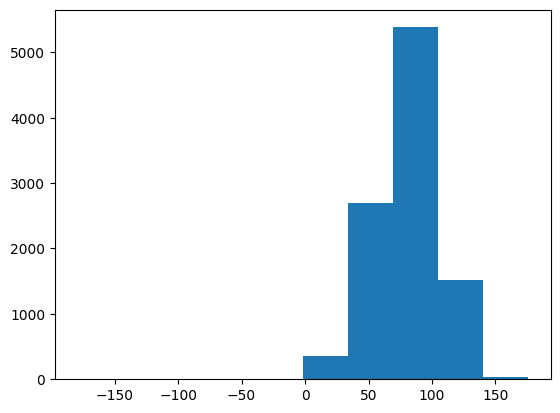

In [8]:
plt.hist(df["ita"])
plt.show()